In [9]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.decomposition import PCA

In [10]:
df=pd.read_csv('clean_kaggle_data_2020.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,206) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Cleaning

In [11]:
# Check the shape of the dataframe
print('Shape of the dataframe: {}'.format(df.shape))

Shape of the dataframe: (10730, 357)


In [12]:
# Check number of missing values in the first 20 columns
df.iloc[:,:20].isnull().sum()

Time from Start to Finish (seconds)        0
Q1                                         0
Q2                                         0
Q3                                         0
Q4                                         0
Q5                                         0
Q6                                         0
Q7_Part_1                               2009
Q7_Part_2                               7974
Q7_Part_3                               5749
Q7_Part_4                               9329
Q7_Part_5                               9037
Q7_Part_6                               8980
Q7_Part_7                               8901
Q7_Part_8                              10555
Q7_Part_9                              10600
Q7_Part_10                              9370
Q7_Part_11                              9623
Q7_Part_12                             10626
Q7_OTHER                                9327
dtype: int64

In [13]:
# Remove all the columns with more than 1000 missing values
new_df=df.loc[:,df.columns[df.isnull().sum().values<1000].values]

In [14]:
# Check number of missing values in each column
new_df.isnull().sum()

Time from Start to Finish (seconds)      0
Q1                                       0
Q2                                       0
Q3                                       0
Q4                                       0
Q5                                       0
Q6                                       0
Q8                                     561
Q11                                    561
Q13                                    561
Q15                                    561
Q20                                      0
Q21                                      0
Q22                                      0
Q24                                      0
Q25                                    159
Q24_Encoded                              1
Q24_buckets                              1
dtype: int64

In [15]:
# Get the questions with missing values
print('Q8:',df.loc[0,'Q8'])
print('Q11:',df.loc[0,'Q11'])
print('Q13:',df.loc[0,'Q13'])
print('Q15:',df.loc[0,'Q15'])
print('Q25:',df.loc[0,'Q25'])

Q8: What programming language would you recommend an aspiring data scientist to learn first? - Selected Choice
Q11: What type of computing platform do you use most often for your data science projects? - Selected Choice
Q13: Approximately how many times have you used a TPU (tensor processing unit)?
Q15: For how many years have you used machine learning methods?
Q25: Approximately how much money have you (or your team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years (approximate $USD)?


In [16]:
# Remove the first row
new_df=new_df.iloc[1:,:]

In [17]:
# Fill missing values with most common response
clean_df=new_df.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [18]:
# Check if there is any missing value in clean_df
clean_df.isnull().sum()

Time from Start to Finish (seconds)    0
Q1                                     0
Q2                                     0
Q3                                     0
Q4                                     0
Q5                                     0
Q6                                     0
Q8                                     0
Q11                                    0
Q13                                    0
Q15                                    0
Q20                                    0
Q21                                    0
Q22                                    0
Q24                                    0
Q25                                    0
Q24_Encoded                            0
Q24_buckets                            0
dtype: int64

In [19]:
# Check the data type
clean_df.dtypes

Time from Start to Finish (seconds)     object
Q1                                      object
Q2                                      object
Q3                                      object
Q4                                      object
Q5                                      object
Q6                                      object
Q8                                      object
Q11                                     object
Q13                                     object
Q15                                     object
Q20                                     object
Q21                                     object
Q22                                     object
Q24                                     object
Q25                                     object
Q24_Encoded                            float64
Q24_buckets                             object
dtype: object

In [20]:
# Transform first column and Q24_Encoded to integer
clean_df=clean_df.astype({'Time from Start to Finish (seconds)':'int64','Q24_Encoded':'int64'})

In [21]:
# Categorical features that can use self-encoding
le_features=['Q1','Q6','Q13','Q15','Q20','Q21','Q25']
# Categorical features that can use dummy values
dummy_features=['Q2','Q3','Q4','Q5','Q8','Q11','Q22']

In [22]:
# Get unique values for features using self-encoding
for feature in le_features:
    print('Unique values for {}'.format(feature))
    print(clean_df.loc[:,feature].unique())

Unique values for Q1
['30-34' '35-39' '22-24' '55-59' '50-54' '25-29' '18-21' '40-44' '60-69'
 '45-49' '70+']
Unique values for Q6
['5-10 years' '10-20 years' '1-2 years' '< 1 years' '3-5 years'
 '20+ years' 'I have never written code']
Unique values for Q13
['2-5 times' 'Never' '6-25 times' 'Once' 'More than 25 times']
Unique values for Q15
['1-2 years' 'I do not use machine learning methods' '3-4 years'
 '2-3 years' 'Under 1 year' '4-5 years' '5-10 years' '20 or more years'
 '10-20 years']
Unique values for Q20
['10,000 or more employees' '1000-9,999 employees' '250-999 employees'
 '0-49 employees' '50-249 employees']
Unique values for Q21
['20+' '0' '5-9' '1-2' '3-4' '10-14' '15-19']
Unique values for Q25
['$100,000 or more ($USD)' '$0 ($USD)' '$10,000-$99,999' '$1-$99'
 '$1000-$9,999' '$100-$999']


In [23]:
# Transform Q1 using self-encoding
Q1_encode={'18-21':0,
                       '22-24':1,
                       '25-29':2,
                       '30-34':3,
                       '35-39':4,
                       '40-44':5,
                       '45-49':6,
                        '50-54':7,
                        '55-59':8,
                        '60-69':9,
                        '70+':10}
clean_df['Q1_Encoded']=clean_df.loc[:,'Q1'].map(Q1_encode)

In [24]:
# Transform Q6 using self-encoding
Q6_encode={'I have never written code':0,
                       '< 1 years':1,
                       '1-2 years':2,
                       '3-5 years':3,
                       '5-10 years':4,
                       '10-20 years':5,
                        '20+ years':6}
clean_df['Q6_Encoded']=clean_df.loc[:,'Q6'].map(Q6_encode)

In [25]:
# Transform Q13 using self-encoding
Q13_encode={'Never':0,
                       'Once':1,
                       '2-5 times':2,
                       '6-25 times':3,
                       'More than 25 times':4}
clean_df['Q13_Encoded']=clean_df.loc[:,'Q13'].map(Q13_encode)

In [26]:
# Transform Q15 using self-encoding
Q15_encode={'I do not use machine learning methods':0,
                       'Under 1 year':1,
                       '1-2 years':2,
                       '2-3 years':3,
                       '3-4 years':4,
                       '4-5 years':5,
                        '5-10 years':6,
                        '10-20 years':7,
                        '20 or more years':8}
clean_df['Q15_Encoded']=clean_df.loc[:,'Q15'].map(Q15_encode)

In [27]:
# Transform Q20 using self-encoding
Q20_encode={'0-49 employees':0,
                       '50-249 employees':1,
                       '250-999 employees':2,
                       '1000-9,999 employees':3,
                       '10,000 or more employees':4}
clean_df['Q20_Encoded']=clean_df.loc[:,'Q20'].map(Q20_encode)

In [28]:
# Transform Q21 using self-encoding
Q21_encode={'0':0,
                        '1-2':1,
                        '3-4':2,
                        '5-9':3,
                        '10-14':4,
                        '15-19':5,
                        '20+':6}
clean_df['Q21_Encoded']=clean_df.loc[:,'Q21'].map(Q21_encode)

In [29]:
# Transform Q25 using self-encoding
Q25_encode={'$0 ($USD)':0,
                        '$1-$99':1,
                        '$100-$999':2,
                        '$1000-$9,999':3,
                        '$10,000-$99,999':4,
                        '$100,000 or more ($USD)':5}
clean_df['Q25_Encoded']=clean_df.loc[:,'Q25'].map(Q25_encode)

In [30]:
# Transform features using dummy values
for feature in dummy_features:
    dummy_df=pd.get_dummies(clean_df.loc[:,feature],prefix=feature)
    clean_df=clean_df.join(dummy_df)

# EDA and Feature Selection

In [47]:
# Extract features
features_df=clean_df.iloc[:,18:]
features_df['Time from Start to Finish (seconds)']=clean_df.iloc[:,0]
# Extract target label
target=clean_df.iloc[:,16]

In [32]:
# Combine features and target into one dataframe
combined_df=features_df.join(target)

Text(0.5, 1.0, 'Heatmap of correlation')

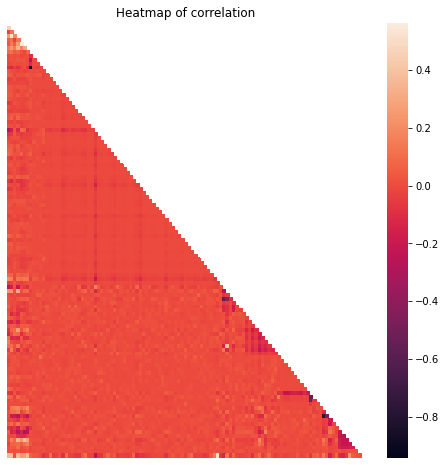

In [33]:
# Heatmap of correlation
mask = np.zeros_like(combined_df.corr()*-1)
mask[np.triu_indices_from(mask)] = True

fig,ax = plt.subplots(figsize=(8,8))
sns.heatmap(combined_df.corr(), mask=mask, annot=False,xticklabels=False, yticklabels=False).set_title('Heatmap of correlation')

In [34]:
# Find highly correlated fetures
print('Number of highly correlated features: {}'.format(((combined_df.corr()>0.7).sum().values != 1).astype(int).sum()))

Number of highly correlated features: 0


Text(0.5, 1.0, 'Correlation between each feature and target')

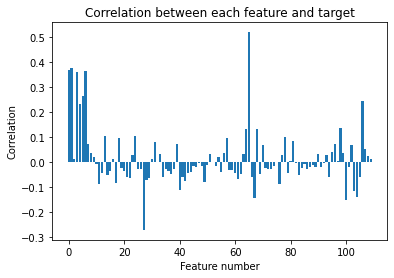

In [35]:
# Plot correlation of each feature to target
correlation=features_df.apply(lambda x: x.corr(target))
plt.bar(height=correlation.values,x=range(110))
plt.xlabel('Feature number')
plt.ylabel('Correlation')
plt.title('Correlation between each feature and target')

In [36]:
# Find most positivly related feature in the dataset
print('Most related feature: {}'.format(features_df.columns[np.argmax(correlation)]))

Most related feature: Q3_United States of America


In [37]:
# Find most negatively related feature in the dataset
print('Most related feature: {}'.format(features_df.columns[np.argmin(correlation)]))

Most related feature: Q3_India


In [38]:
# Feature engineering
# Select correlation for countries
country_correlation=correlation[12:67]
# Select countries with correalation less than 0.1
c=country_correlation[np.abs(country_correlation.values)<0.1].index.values
# Combine those countries in one column
combined_feature=features_df.loc[:,c].sum(axis=1)
# Add a new column to features dataframe
features_df['Q3_Combined']=combined_feature.values
# Drop the countries with correlation less than 1
features_df=features_df.drop(c,axis=1)

In [39]:
# Split the dataset into train and test
X_train,X_test,y_train,y_test=train_test_split(features_df,target,test_size=0.3,random_state=0)

In [40]:
# Feature selection using Chi-2
feature_selector=SelectKBest(chi2).fit(X_train, y_train)
# Select features with p-value less than 0.05
selected_cols=(features_df.columns[feature_selector.pvalues_<0.05]).values
# Extract selected feature for training data and test data
X_train=X_train.loc[:,selected_cols]
X_test=X_test.loc[:,selected_cols]

In [41]:
# Check number of features left in the dataset
print('# of features after selection: {}'.format(X_train.shape[1]))

# of features after selection: 44


In [42]:
# Standardize data
scaler=preprocessing.StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_train=pd.DataFrame(X_train)
X_test=scaler.transform(X_test)
X_test=pd.DataFrame(X_test)

In [43]:
# Dimensionality reduction
pca=PCA(n_components=15)
pca.fit(X_train)
X_train=pd.DataFrame(pca.transform(X_train))
X_test=pd.DataFrame(pca.transform(X_test))
print('Explained variance ratio: {}'.format(np.sum(pca.explained_variance_ratio_)))

Explained variance ratio: 0.5154768822407114


# Model Implementation

In [44]:
# Implement the model
lr=LogisticRegression(solver='saga',penalty='elasticnet',l1_ratio=0)
kfold = KFold(n_splits=10,shuffle=True,random_state=0)
kfold.get_n_splits(X_train)
accuracy = np.zeros(10)
np_idx = 0
probabilities_dict={}
n=1
# For each fold
for train_idx, test_idx in kfold.split(X_train):
    # Get the training and test data
    X_train_cv, X_test_cv = X_train.values[train_idx], X_train.values[test_idx]
    y_train_cv, y_test_cv = y_train.values[train_idx], y_train.values[test_idx]
    prob_list=[]
    # For each of the encoded salaray range
    for i in range(14):
        # Transform training target into binary label
        new_y_train_cv=(y_train_cv<=i).astype(int)
        # Fit the model
        lr.fit(X_train_cv,new_y_train_cv)
        # Get the probabilty for positive target
        prob=lr.predict_proba(X_test_cv)[:,1]
        # Append the probabilities to the list
        prob_list.append(prob)
    probabilities=np.array(prob_list)
    adjusted_prob_list=[]
    # For each of the classification
    for i in range(15):
        # For the first classification just append the result
        if i == 0:
            adjusted_prob_list.append(probabilities[0,:])
        # Else current probability result minus previous probability result
        elif i<14:
            adjusted_prob_list.append(probabilities[i,:]-probabilities[i-1,:])
        # Last class equals 1-previous probability
        else:
            adjusted_prob_list.append(1-probabilities[13,:])
    adjusted_probabilities=np.array(adjusted_prob_list)
    # Find the maximum value in each column and output the index as prediction 
    prediction=np.argmax((adjusted_probabilities==adjusted_probabilities.max(axis=0,keepdims=1)).astype(int),axis=0)
    # Calcualte accuracy score
    accuracy[np_idx]=accuracy_score(y_test_cv,prediction)
    # Put current fold's result in the probabilities dictionary
    probabilities_dict[n]=adjusted_probabilities
    n=n+1
    np_idx=np_idx+1

In [60]:
# prediction label to bucket encoding
bucket_encode={0:'0-9,999',
                                1:'10,000-19,999',
                                2:'20,000-29,999',
                                3:'30,000-39,999',
                                4:'40,000-49,999',
                                5:'50,000-59,999',
                                6:'60,000-69,999',
                                7:'70,000-79,999',
                                8:'80,000-89,999',
                                9:'90,000-99,999',
                                10:'100,000-124,999',
                                11:'125,000-149,999',
                                12:'150,000-199,999',
                                13:'200,000-249,999',
                                14:'>250,000'}
bucket_set=('0-9,999','10,000-19,999','20,000-29,999','30,000-39,999','40,000-49,999','50,000-59,999','60,000-69,999','70,000-79,999','80,000-89,999','90,000-99,999','100,000-124,999','125,000-149,999','150,000-199,999','200,000-249,999','>250,000')

([<matplotlib.axis.XTick at 0x7fc08520b550>,
 [Text(0, 0, '0-9,999'),
  Text(0, 0, '10,000-19,999'),
  Text(0, 0, '20,000-29,999'),
  Text(0, 0, '30,000-39,999'),
  Text(0, 0, '40,000-49,999'),
  Text(0, 0, '50,000-59,999'),
  Text(0, 0, '60,000-69,999'),
  Text(0, 0, '70,000-79,999'),
  Text(0, 0, '80,000-89,999'),
  Text(0, 0, '90,000-99,999'),
  Text(0, 0, '100,000-124,999'),
  Text(0, 0, '125,000-149,999'),
  Text(0, 0, '150,000-199,999'),
  Text(0, 0, '200,000-249,999'),
  Text(0, 0, '>250,000')])

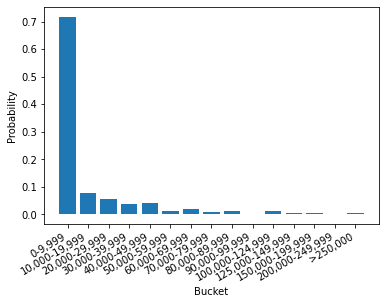

In [66]:
# Probability distribution for one of the training data
plt.bar(height=adjusted_probabilities[:,23],x=range(15))
plt.xlabel('Bucket')
plt.ylabel('Probability')
plt.xticks(range(15),bucket_set,rotation=30,ha='right')

([<matplotlib.axis.XTick at 0x7fc0851b5f90>,
 [Text(0, 0, '0-9,999'),
  Text(0, 0, '10,000-19,999'),
  Text(0, 0, '20,000-29,999'),
  Text(0, 0, '30,000-39,999'),
  Text(0, 0, '40,000-49,999'),
  Text(0, 0, '50,000-59,999'),
  Text(0, 0, '60,000-69,999'),
  Text(0, 0, '70,000-79,999'),
  Text(0, 0, '80,000-89,999'),
  Text(0, 0, '90,000-99,999'),
  Text(0, 0, '100,000-124,999'),
  Text(0, 0, '125,000-149,999'),
  Text(0, 0, '150,000-199,999'),
  Text(0, 0, '200,000-249,999'),
  Text(0, 0, '>250,000')])

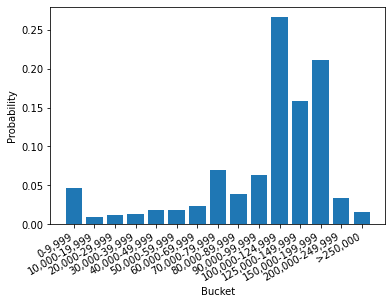

In [67]:
# Probability distribution for one of the training data
plt.bar(height=adjusted_probabilities[:,99],x=range(15))
plt.xlabel('Bucket')
plt.ylabel('Probability')
plt.xticks(range(15),bucket_set,rotation=30,ha='right')

In [68]:
print('Accuracy of each fold:',accuracy)

Accuracy of each fold: [0.42343542 0.44074567 0.42609854 0.4460719  0.42876165 0.43941411
 0.42210386 0.44340879 0.41810919 0.41544607]


In [69]:
# Average accuracy and variance
acc_mean=np.round(np.array(accuracy).mean(),4)
acc_var=np.round(np.array(accuracy).var(),5)
print('The average accuracy is {} with variance {}'.format(acc_mean,acc_var))

The average accuracy is 0.4304 with variance 0.00011


# Model Tuning

In [72]:
# Gird search
f1_score_dict={}
for c in [0.01,0.1,1,10]:
    for l1 in [0,0.5,1]:
        lr=LogisticRegression(solver='saga',C=c,l1_ratio=l1,penalty='elasticnet')
        f1_score_array = np.zeros(10)
        np_idx = 0
        probabilities_dict={}
        n=1
        # For each fold
        for train_idx, test_idx in kfold.split(X_train):
            # Get the training and test data
            X_train_cv, X_test_cv = X_train.values[train_idx], X_train.values[test_idx]
            y_train_cv, y_test_cv = y_train.values[train_idx], y_train.values[test_idx]
            prob_list=[]
            # For each of the encoded salaray range
            for i in range(14):
                # Transform training target into binary
                new_y_train_cv=(y_train_cv<=i).astype(int)
                # Fit the model
                lr.fit(X_train_cv,new_y_train_cv)
                # Get the probabilty for positive target
                prob=lr.predict_proba(X_test_cv)[:,1]
                # Append the probabilities to the list
                prob_list.append(prob)
            probabilities=np.array(prob_list)
            adjusted_prob_list=[]
            # For each of the classification
            for i in range(15):
                # For the first classification just append the result
                if i == 0:
                    adjusted_prob_list.append(probabilities[0,:])
                # Else current probability result minus previous probability result
                elif i<14:
                    adjusted_prob_list.append(probabilities[i,:]-probabilities[i-1,:])
                # Last class equals 1-previous probability
                else:
                    adjusted_prob_list.append(1-probabilities[13,:])
            adjusted_probabilities=np.array(adjusted_prob_list)
            # Find the maximum value in each column and output the index as prediction 
            prediction=np.argmax((adjusted_probabilities==adjusted_probabilities.max(axis=0,keepdims=1)).astype(int),axis=0)
            # Calcualte accuracy score
            f1_score_array[np_idx]=f1_score(y_test_cv,prediction,average='micro')
            # Put current fold's result in the probabilities dictionary
            probabilities_dict[n]=adjusted_probabilities
            n=n+1
            np_idx=np_idx+1
        name=str(c)+'-'+str(l1)
        f1_score_dict[name]=f1_score_array

In [73]:
# Find best hyperparameters
mean_f1_list=[]
for f1 in f1_score_dict.values():
    mean_f1=f1.mean()
    mean_f1_list.append(mean_f1)
highest_f1_index=np.argmax(np.array(mean_f1_list))
best_param=list(f1_score_dict.keys())[highest_f1_index]
print('Best parameters: {}'.format(best_param))

Best parameters: 0.01-0


In [74]:
# Implement the model with best hypterparmeters
lr=LogisticRegression(solver='saga',C=0.01,l1_ratio=0,penalty='elasticnet')
accuracy = np.zeros(10)
np_idx = 0
probabilities_dict={}
n=1
# For each fold
for train_idx, test_idx in kfold.split(X_train):
    # Get the training and test data
    X_train_cv, X_test_cv = X_train.values[train_idx], X_train.values[test_idx]
    y_train_cv, y_test_cv = y_train.values[train_idx], y_train.values[test_idx]
    prob_list=[]
    # For each of the encoded salaray range
    for i in range(14):
        # Transform training target into binary
        new_y_train_cv=(y_train_cv<=i).astype(int)
        # Fit the model
        lr.fit(X_train_cv,new_y_train_cv)
        # Get the probabilty for positive target
        prob=lr.predict_proba(X_test_cv)[:,1]
        # Append the probabilities to the list
        prob_list.append(prob)
    probabilities=np.array(prob_list)
    adjusted_prob_list=[]
    # For each of the classification
    for i in range(15):
        # For the first classification just append the result
        if i == 0:
            adjusted_prob_list.append(probabilities[0,:])
        # Else current probability result minus previous probability result
        elif i<14:
            adjusted_prob_list.append(probabilities[i,:]-probabilities[i-1,:])
        # Last class equals 1-previous probability
        else:
            adjusted_prob_list.append(1-probabilities[13,:])
    adjusted_probabilities=np.array(adjusted_prob_list)
    # Find the maximum value in each column and output the index as prediction 
    prediction=np.argmax((adjusted_probabilities==adjusted_probabilities.max(axis=0,keepdims=1)).astype(int),axis=0)
    # Calcualte accuracy score
    accuracy[np_idx]=accuracy_score(y_test_cv,prediction)
    # Put current fold's result in the probabilities dictionary
    probabilities_dict[n]=adjusted_probabilities
    n=n+1
    np_idx=np_idx+1

In [75]:
# Average accuracy and variance
acc_mean=np.round(np.array(accuracy).mean(),4)
acc_var=np.round(np.array(accuracy).var(),4)
print('The average accuracy is {} with variance {}'.format(acc_mean,acc_var))

The average accuracy is 0.4309 with variance 0.0001


# Testing&Discussion

In [76]:
# Train the model with best hyperparameters with all training data
# And make prediction for training data and test data
lr=LogisticRegression(solver='saga',C=0.01,l1_ratio=0.5,penalty='elasticnet')
# Probability lists
train_prob_list=[]
test_prob_list=[]
# For each of the encoded salaray range
for i in range(14):
    # Transform training target into binary
    new_y_train=(y_train<=i).astype(int)
    # Fit the model
    lr.fit(X_train,new_y_train)
    # Get the probabilty for positive target
    train_prob=lr.predict_proba(X_train)[:,1]
    test_prob=lr.predict_proba(X_test)[:,1]
    # Append the probabilities to the list
    train_prob_list.append(train_prob)
    test_prob_list.append(test_prob)
train_probabilities=np.array(train_prob_list)
test_probabilities=np.array(test_prob_list)
train_adjusted_prob_list=[]
test_adjusted_prob_list=[]
for i in range(15):
    # For the first classification just append the result
    if i == 0:
        train_adjusted_prob_list.append(train_probabilities[0,:])
        test_adjusted_prob_list.append(test_probabilities[0,:])
    # Else current probability result minus previous probability result
    elif i<14:
        train_adjusted_prob_list.append(train_probabilities[i,:]-train_probabilities[i-1,:])
        test_adjusted_prob_list.append(test_probabilities[i,:]-test_probabilities[i-1,:])
    # Last class equals 1-previous probability
    else:
        train_adjusted_prob_list.append(1-train_probabilities[13,:])
        test_adjusted_prob_list.append(1-test_probabilities[13,:])
    train_adjusted_probabilities=np.array(train_adjusted_prob_list)
    test_adjusted_probabilities=np.array(test_adjusted_prob_list)
    # Find the maximum value in each column and output the index as prediction 
    train_prediction=np.argmax((train_adjusted_probabilities==train_adjusted_probabilities.max(axis=0,keepdims=1)).astype(int),axis=0)
    test_prediction=np.argmax((test_adjusted_probabilities==test_adjusted_probabilities.max(axis=0,keepdims=1)).astype(int),axis=0)


In [80]:
# Convert predicted lable to bucket
train_prediction_bucket=pd.Series(train_prediction).map(bucket_encode)
trest_prediction_bucket=pd.Series(test_prediction).map(bucket_encode)

In [81]:
# Print the accuracy for training data and test data
print('Accuracy on training set: {}'.format(np.round(accuracy_score(y_train,train_prediction),4)))
print('Accuracy on testing set: {}'.format(np.round(accuracy_score(y_test,test_prediction),4)))

Accuracy on training set: 0.4344
Accuracy on testing set: 0.4331


Text(0.5, 1.0, 'Distribution of training data target')

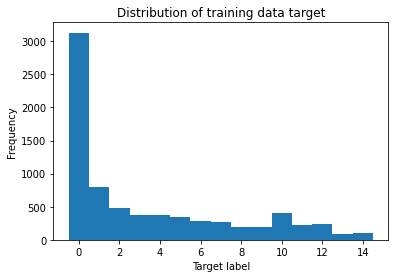

In [89]:
# Plot distribution of training target
bins=np.arange(16)-0.5
plt.hist(y_train,bins,label=bucket_set)
plt.xlabel('Target label')
plt.ylabel('Frequency')
plt.title('Distribution of training data target')

Text(0.5, 1.0, 'Distribution of training data prediction')

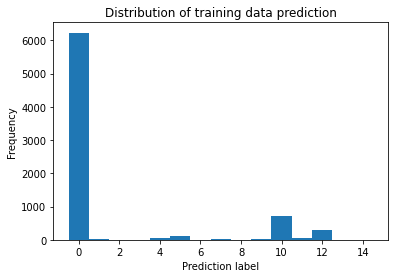

In [90]:
# Plot distribution of training prediction
plt.hist(train_prediction,bins)
plt.xlabel('Prediction label')
plt.ylabel('Frequency')
plt.title('Distribution of training data prediction')

Text(0.5, 1.0, 'Distribution of testing data target')

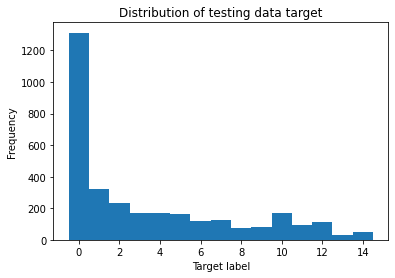

In [91]:
# Plot distribution of test target
plt.hist(y_test,bins)
plt.xlabel('Target label')
plt.ylabel('Frequency')
plt.title('Distribution of testing data target')

Text(0.5, 1.0, 'Distribution of testing data prediction')

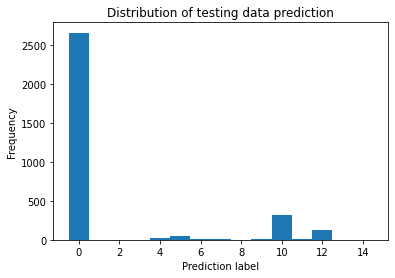

In [92]:
# Plot distribution of test prediction
plt.hist(test_prediction,bins)
plt.xlabel('Prediction label')
plt.ylabel('Frequency')
plt.title('Distribution of testing data prediction')